In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sp_inference import processes, model, logging
from sp_inference.utilities import general as utils

In [2]:
# Settings of the logger, which is shared by all library components
# The data is saved into a pre-defined file structure to reduce the number of settings
logSettings = {
    "output_directory":           "04_met_moments",
    "verbose":                    True
}

# Settings for the generation of data from a prototypical stochastic process
dataSettings = {
    "process_type":               "Dr31Di20Process",
    "drift_parameters":           [2, 3],
    "diffusion_parameters":       [1, 2],
    "standard_deviation":         0.001,
    "rng_seed":                   0,
    "num_points":                 50,
    "domain_bounds":              [-1.5, 1.5]
}

# Settings for the inference model
modelSettings = {
    "params_to_infer":            "all",
    "model_type":                 "mean_exit_time_moments",
    "is_stationary":              True
}

# Settings of the Bi-Laplacian prior transferred from the hIPPYlib library
priorSettings = {
    "mean_function":              [lambda x: -1*x, lambda x: 2.5*np.ones(x.size)],
    "gamma":                      1,
    "delta":                      1,
    "robin_bc":                   False
}

# Settings for the FEM solver of the PDE constraint used for the inference problem
feSettings = {
    "num_mesh_points":            500,
    "boundary_locations":         [-1.5, 1.5],
    "boundary_values":            [(0, 0), (0, 0)],
    "element_degrees":            [1, 1],
    "squared_diffusion_function": lambda x: np.ones(x.shape)
}

# Settings of the solver for the linearized inference problem (MAP).
# This is an inexact Newton-CG solver with Armijo line search for globalization
solverSettings = {
    "rel_tolerance":              1e-6,
    "abs_tolerance":              1e-12,
    "max_iter":                   50,
    "GN_iter":                    5,
    "c_armijo":                   1e-4,
    "max_backtracking_iter":      10
}

# Settings for the construction of the reduced Hessian of the linearized problem about the MAP
hessianSettings = {
    "num_eigvals":                20,
    "num_oversampling":           5
}

In [3]:
try:
    os.system('rm -r ' + logSettings["output_directory"])
except:
    pass

# The logger is instantiated as a separate object that is passed to other components
logger = logging.Logger(logSettings["verbose"],
                        logSettings["output_directory"])

rm: cannot remove '04_met_moments': No such file or directory


In [4]:
randGenerator = np.random.default_rng(dataSettings["rng_seed"])
randLocs = randGenerator.uniform(*dataSettings["domain_bounds"], dataSettings["num_points"])
dataSettings["domain_points"] = randLocs

processType = processes.get_process(dataSettings["process_type"])
process = processType(dataSettings["drift_parameters"],
                      dataSettings["diffusion_parameters"],
                      logger)

forwardNoisy, forwardExact = process.generate_data_mean_exit_time_moments(dataSettings["domain_points"],
                                                                          dataSettings["standard_deviation"], 
                                                                          dataSettings["rng_seed"], 
                                                                          feSettings)

================== Invoke Dr31Di20Process ==================
 
Drift Coefficient(s): [2, 3] 
Diffusion Coefficient(s): [1, 2] 

Generate MET Moments data:         Solving linear variational problem.
Successful 



In [7]:
exactDrift = process.compute_drift(randLocs)
exactParamData = [randLocs, exactDrift]
randForwardData = [randLocs, forwardNoisy]
exactForwardData = [randLocs,  forwardExact]

# New settings dict for the misfit functional
misFitSettings = {
    "data_locations": randLocs,
    "data_values": forwardNoisy,
    "data_var": (dataSettings["standard_deviation"]**2,)*2
}

In [8]:
inferenceModel = model.SDEInferenceModel(modelSettings,
                                         priorSettings,
                                         feSettings,
                                         misFitSettings,
                                         logger=logger)

# Get drift mean and variance, along with mean exit time solution when using prior info
priorMeanData, priorVarianceData, priorForwardData = inferenceModel.get_prior_info("Randomized")

================== Invoke Inference Model ==================
 
Construct PDE Problem:             Successful 

Construct Prior:                   Successful 

Construct Misfit:                  Successful 

 
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
# Data for mean, variance and forward solution is returned in form of x-y-value pairs over the spacial domain
mapMeanData, mapVarianceData, mapForwardData, hessEigVals \
    = inferenceModel.compute_gr_posterior(solverSettings, hessianSettings)

=============== Conduct Linearized Inference ===============
 
Solve for MAP: 
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    9.101315e+06    9.101314e+06    5.979501e-01   -1.318999e+08   1.624145e+08   1.000000e+00   5.000000e-01
  2   1    7.797992e+05    7.797969e+05    2.269749e+00   -1.808847e+07   2.417097e+07   1.000000e+00   3.857755e-01
  3   1    6.184036e+04    6.183667e+04    3.683805e+00   -1.470039e+06   3.563124e+06   1.000000e+00   1

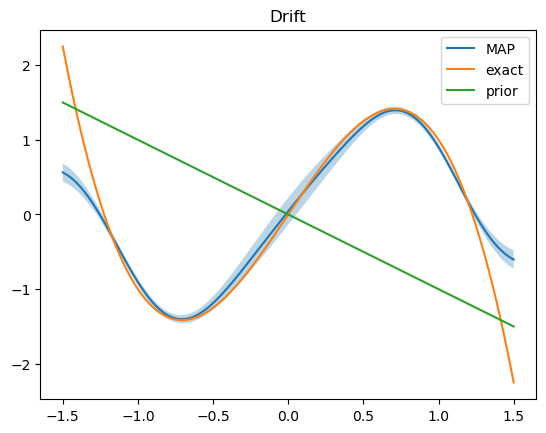

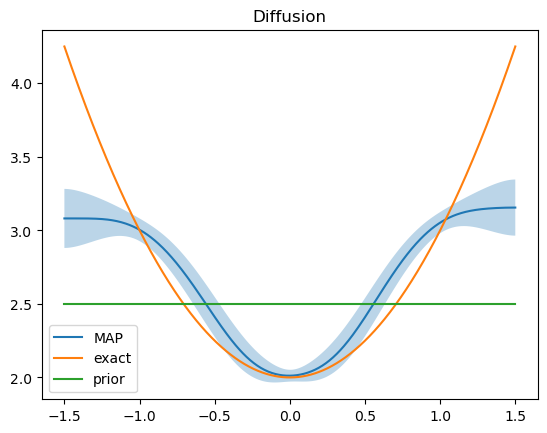

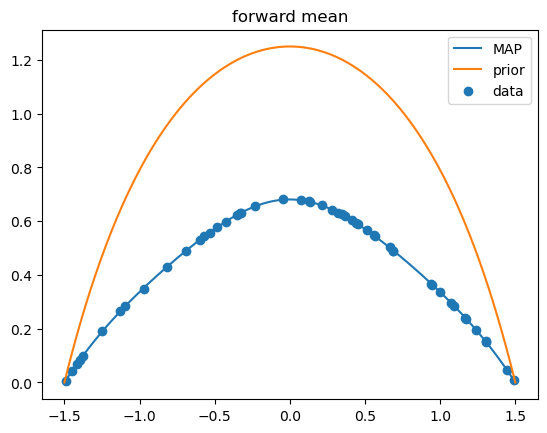

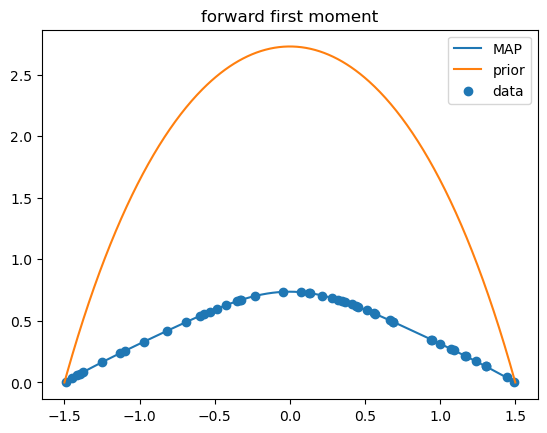

In [10]:
xValues = np.linspace(-1.5, 1.5, 1001)
exactDrift = process.compute_drift(xValues)
exactDiffusion = process.compute_squared_diffusion(xValues)

_, ax = plt.subplots()
ax.set_title('Drift')
ax.plot(mapMeanData[0], mapMeanData[1][:, 0], label='MAP')
ax.fill_between(mapMeanData[0], mapMeanData[1][:, 0] - 1.96*np.sqrt(mapVarianceData[1][:, 0]),
                                  mapMeanData[1][:, 0] + 1.96*np.sqrt(mapVarianceData[1][:, 0]),
                                  alpha=0.3)
ax.plot(xValues, exactDrift, label='exact')
ax.plot(priorMeanData[0], priorMeanData[1][:, 0], label='prior')
ax.legend()

_, ax = plt.subplots()
ax.set_title('Diffusion')
ax.plot(mapMeanData[0], mapMeanData[1][:, 1], label='MAP')
ax.fill_between(priorMeanData[0], mapMeanData[1][:, 1] - 1.96*np.sqrt(mapVarianceData[1][:, 1]),
                                  mapMeanData[1][:, 1] + 1.96*np.sqrt(mapVarianceData[1][:, 1]),
                                  alpha=0.3)
ax.plot(xValues, exactDiffusion, label='exact')
ax.plot(priorMeanData[0], priorMeanData[1][:, 1], label='prior')
ax.legend()

priorForwardDataReshaped = []
priorForwardDataReshaped.append(utils.reshape_to_np_format(priorForwardData[0], 2))
priorForwardDataReshaped.append(utils.reshape_to_np_format(priorForwardData[1], 2))
mapForwardDataReshaped = []
mapForwardDataReshaped.append(utils.reshape_to_np_format(mapForwardData[0], 2))
mapForwardDataReshaped.append(utils.reshape_to_np_format(mapForwardData[1], 2))

_, ax = plt.subplots()
ax.set_title('forward mean')
ax.plot(mapForwardDataReshaped[0][:, 0], mapForwardDataReshaped[1][:, 0], label='MAP')
ax.plot(priorForwardDataReshaped[0][:, 0], priorForwardDataReshaped[1][:, 0], label='prior')
ax.scatter(randLocs, forwardNoisy[:, 0], label='data')
ax.legend()

_, ax = plt.subplots()
ax.set_title('forward first moment')
ax.plot(mapForwardDataReshaped[0][:, 1], mapForwardDataReshaped[1][:, 1], label='MAP')
ax.plot(priorForwardDataReshaped[0][:, 1], priorForwardDataReshaped[1][:, 1], label='prior')
ax.scatter(randLocs, forwardNoisy[:, 1], label='data')
ax.legend()